Python Notebook to visulize the `emacs` subreddit data. </br>
It takes the subreddit feature CSV, process, and plot the data to derieve conclusions.

In [ ]:
#Download and import all dependancies
import nltk
import math
from nltk.tokenize import word_tokenize, RegexpTokenizer
import numpy as np
import pandas as pd
import warnings
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
import collections
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(style='whitegrid', context='notebook', palette='cubehelix') #setting style for consistent plots

In [ ]:
#download dataset
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Mount Google drive, provide auth code to write/read from G drive
drive.mount("/drive")
#warnings.filterwarnings('ignore')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#Import the dataset-file
df = pd.read_csv("/drive/My Drive/Colab Notebooks/emacs_feature.csv") 
print(df.shape)
df.head()

(1255, 8)


,post,title,date_created,author,post_sentiment,title_sentiment,reddit_score,num_comments
0,I’ve spent the day trying to configure emacs-s...,Thoughts on a client-server editor model like ...,01-01-2020,w3_ar3_l3g10n,Positive,Positive,1,7
1,,makem.sh: Makefile-like script for easily test...,01-01-2020,github-alphapapa,Neutral,Positive,1,1
2,Perhaps the only thing I miss about Vim is how...,Changing the behavior of RET in Emacs to be li...,01-01-2020,rock-emacs,Positive,Positive,1,7
3,Currently `notmuch` is not available on Window...,Running notmuch on Windows Emacs,01-01-2020,_priyadarshan,Positive,Neutral,1,6
4,,org-sync: synchronize your github/gitlab issue...,01-01-2020,karlicoss,Neutral,Neutral,1,2


## Plot the overall sentiment of posts from `emacs` subreddit:





Positive    651
Neutral     404
Negative    200
Name: post_sentiment, dtype: int64


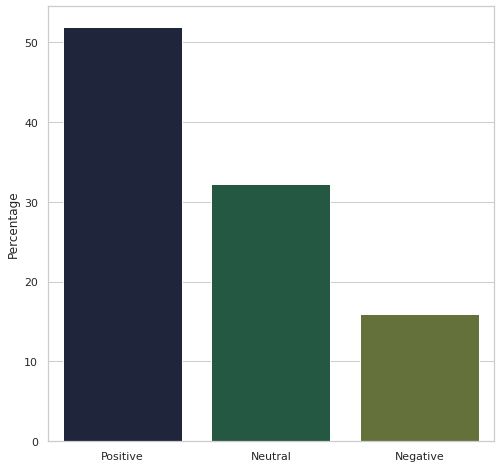

In [ ]:
print(df.post_sentiment.value_counts())

fig, ax = plt.subplots(figsize=(8, 8))
counts = df.post_sentiment.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Positive', 'Neutral', 'Negative'])
ax.set_ylabel("Percentage")

plt.show()

Our sentiment Analyser has labelled majority of posts as either `'Positive'` or `'Neutral'`. '`Negative'` posts are about than 16%.

## Plot the overall sentiment of `title` of posts from `emacs` subreddit:

Neutral     902
Positive    208
Negative    145
Name: title_sentiment, dtype: int64


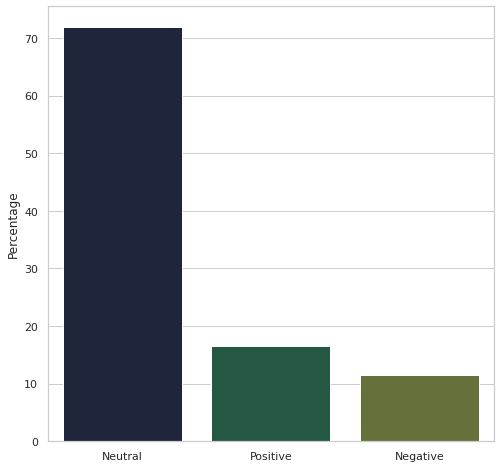

In [ ]:
print(df.title_sentiment.value_counts())

fig, ax = plt.subplots(figsize=(8, 8))
counts = df.title_sentiment.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax.set_ylabel("Percentage")

plt.show()

We can observe that majority of titles have a `'Neutal'` or `'Positive'` title. It is also expected as majority of posts were labelled as `'Positive'`.

In [ ]:
#tokenizer function to get the most used keywords
tokenizer = RegexpTokenizer(r'\w+')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

## Plot the word frequency distribution for `positive` and `negative` words:

We consider words from `postive` labelled `post_sentiment` posts as `positive`, and vice-versa.



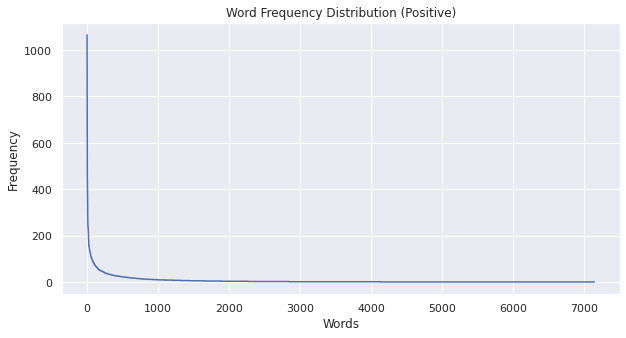

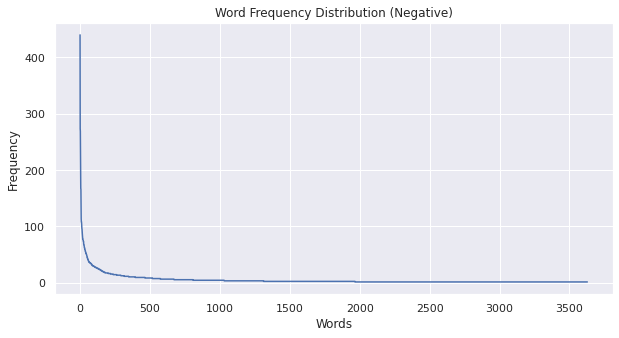

In [ ]:
#Calculate the word frequency
pos_posts = list(df[df.post_sentiment == "Positive"].post)
pos_tokens = process_text(pos_posts)
pos_freq = nltk.FreqDist(pos_tokens)

y_val = [x[1] for x in pos_freq.most_common()]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()


neg_posts = list(df[df.post_sentiment == "Negative"].post)
neg_tokens = process_text(neg_posts)
neg_freq = nltk.FreqDist(neg_tokens)

y_val = [x[1] for x in neg_freq.most_common()]
fig2 = plt.figure(figsize=(10,5))
plt.plot(y_val)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

Since we have more `'Positive'` labelled data we have more positive words. 

## Plot and find the most used `keywords` in posts:




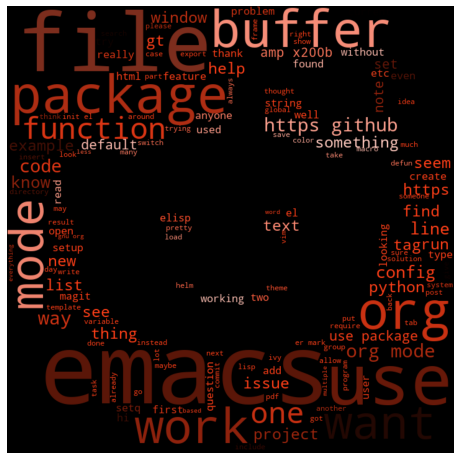

In [ ]:
Mask = np.array(Image.open("/drive/My Drive/Colab Notebooks/reddit.png"))

# We use the ImageColorGenerator library from Wordcloud 
image_colors = ImageColorGenerator(Mask)
mostUsedWords = ' '.join(text for text in pos_tokens)
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(mostUsedWords)
plt.figure(figsize=(8,16))
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

We see the words emacs, file, buffer to be of the largest size hence most frequent.
(The keywords try to make the reddit logo)


## Find the top `authors`:
(*By the frequency of their posts)


[Text(0, 0.5, 'Author'), Text(0.5, 0, 'No of Posts')]

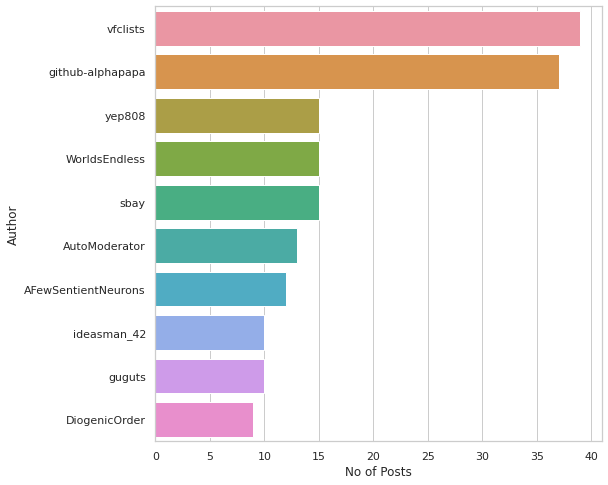

In [ ]:
authors = list(df['author'])
top_authors = collections.Counter(authors)
top10authors = top_authors.most_common(10)
df_author = pd.DataFrame(top10authors)

fig, ax = plt.subplots(figsize=(8, 8))
author_plot = df_author.nlargest(10,columns=1)
sns.barplot(data=author_plot,y=0,x=1)
ax.set(xlabel='No of Posts', ylabel='Author')

Top `author` names are on y-axis and no of posts along the x-axis.

## Time-series plots of Reddit score, Number of Comments and Total Engagement.

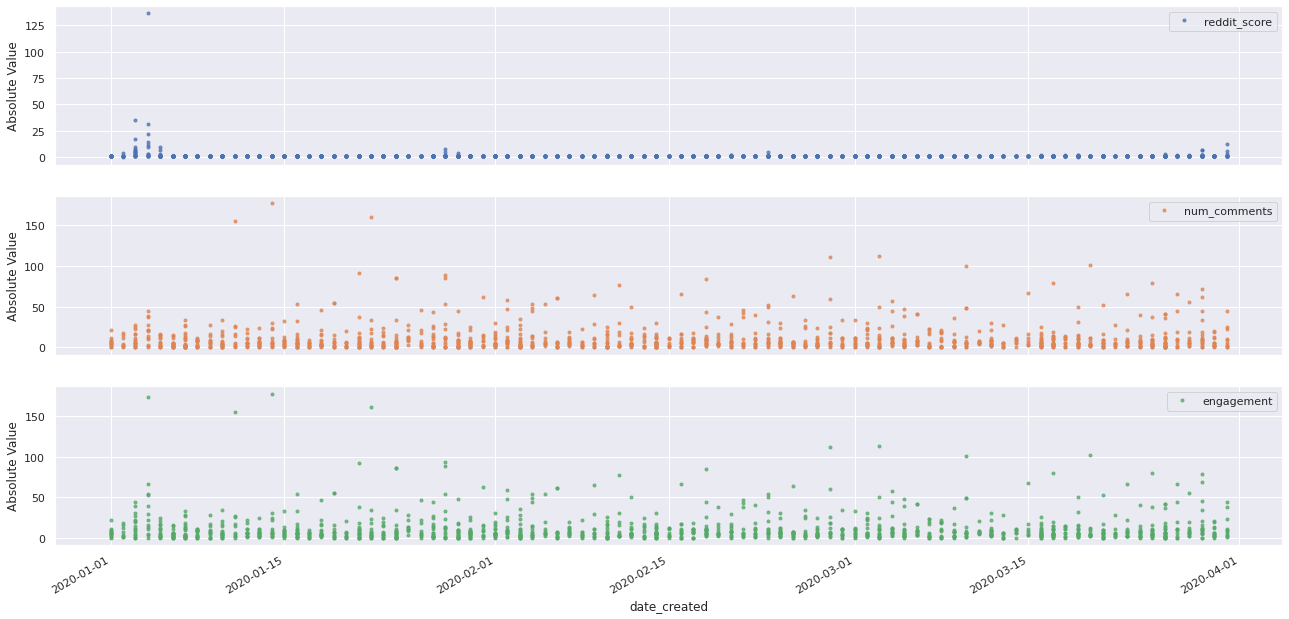

In [ ]:
df_date = df
df_date['date_created']= pd.to_datetime(df_date['date_created'],dayfirst=True) 
df_date.set_index('date_created', inplace=True)

df_date['Year'] = df_date.index.year
df_date['Month'] = df_date.index.month
df_date['engagement'] =df['reddit_score']+df['num_comments'] #calculating engagement of a post as reddit score + comments

cols_plot = ['reddit_score', 'num_comments','engagement']
axes = df_date[cols_plot].plot(marker='.', alpha=0.75, linestyle='None', figsize=(22, 11), subplots=True)
for ax in axes:
    ax.set_ylabel('Absolute Value')

We don't see a correlation between number of likes and number of comments, which is intrestingly different from other social medias. It can be attributed to the behaviour that reddit is more of a knowledge sharing/ meme sharing platform.

## Plot the sentiment of posts: month wise
1 represent the month of January </br>
2 represent the month of February  </br>
3 represent the month of March  </br>

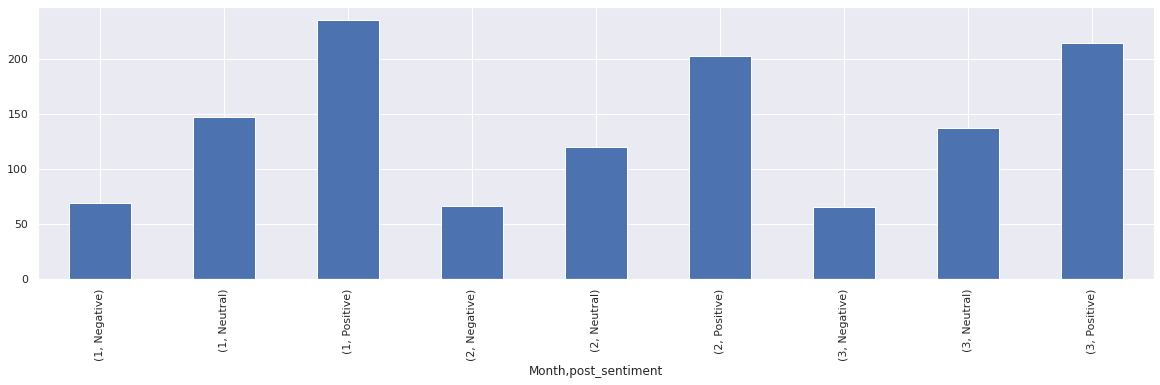

In [ ]:
counts = df_date.groupby(['Month', 'post_sentiment']).agg(len)
df_counts = counts['post']
fig = plt.figure(figsize=(20,5))
df_counts.plot(kind='bar') 
plt.show() 


We see more `Positive` posts in Jan, could be a lot of new year greetings!